# Datenvorbereitung
Zuerst werden Wetterdaten und Produktionsdaten geladen und vorbereitet.

In [96]:
from sqlite3 import connect
import pandas as pd 

DATABASE = "C:\\Users\\studt\\source\\repos\\program\\winMoz\\winMoz\\Data\\Files\\SQLITE\\mzdb_prognosedaten.db"
INSTALLED_CAPACITY = 3.87 * 10e3

conn = connect(DATABASE)

dfHydro = pd.read_sql("SELECT Hydro_Run_of_river_and_poundage, TimeStamp FROM Generation", conn)
dfWeather = pd.read_sql("SELECT * FROM Weather", conn)
dfLoad = pd.read_sql("SELECT Volume, TimeStamp from GridLoad", conn)

# Format dataframe Hydro
dfHydro.rename({"Hydro_Run_of_river_and_poundage": "HydroVolume"}, axis = 1, inplace = True)
dfHydro.loc[:, "HydroVolume"] = pd.to_numeric(dfHydro["HydroVolume"], errors = 'coerce')
dfHydro.loc[:, "TimeStamp"] = pd.to_datetime(dfHydro["TimeStamp"])
dfHydro.loc[:, "HydroScaled"] = dfHydro.loc[:, "HydroVolume"] / (INSTALLED_CAPACITY)

dfHydro = dfHydro.loc[~(dfHydro["HydroVolume"]==0)]
dfHydro.set_index("TimeStamp", inplace = True)
dfHydro.dropna(inplace = True)

# Format dataframe Weather
dfWeather.loc[:, "TimeStamp"] = pd.to_datetime(dfWeather["TimeStamp"])
dfWeather.set_index("TimeStamp", inplace = True)
dfWeather.dropna(inplace = True)

# Format dataframe Load
dfLoad.loc[:, "TimeStamp"] = pd.to_datetime(dfLoad["TimeStamp"])
dfLoad.set_index("TimeStamp", inplace = True)
dfLoad.dropna(inplace = True)

# Test auf Stationarität
Hier wird auf Stationarität getestet wie in https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html beschrieben. Diese Daten werden allerdings gerade nicht verwendet.

In [27]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

adf_test(dfHydro["HydroVolume"])
kpss_test(dfHydro["HydroVolume"])

Results of Dickey-Fuller Test:
Test Statistic                -9.452217e+00
p-value                        4.583972e-16
#Lags Used                     1.600000e+01
Number of Observations Used    1.870870e+05
Critical Value (1%)           -3.430385e+00
Critical Value (5%)           -2.861555e+00
Critical Value (10%)          -2.566778e+00
dtype: float64
Results of KPSS Test:
Test Statistic             2.274594
p-value                    0.010000
Lags Used                244.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Dickey Fuller Test ergibt, dass die Zeitreihe stationär ist da der p-value < 0.05 ist. 
Der KPSS Test ergibt, dass die Zeitreihe nicht-stationär ist da der p-value < 0.05 ist. 

Dementsprechend muss die Zeitreihe differenziert werden. (https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html .)

Differenzierung um Stationarität herzustellen:

In [47]:
from statsmodels.tsa.statespace.tools import diff
dfHydro.loc[:, "HydroVolumeDiff"] = diff(dfHydro["HydroVolume"], k_diff = 1, k_seasonal_diff = 1, seasonal_periods = 96 )
dfHydro.dropna(inplace = True)

adf_test(dfHydro["HydroVolumeDiff"])
kpss_test(dfHydro["HydroVolumeDiff"])

Results of Dickey-Fuller Test:
Test Statistic                    -48.622023
p-value                             0.000000
#Lags Used                         79.000000
Number of Observations Used    186293.000000
Critical Value (1%)                -3.430385
Critical Value (5%)                -2.861556
Critical Value (10%)               -2.566778
dtype: float64
Results of KPSS Test:
Test Statistic             0.000336
p-value                    0.100000
Lags Used                130.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


# Laufwasser skaliert durch Gesamtlast in Deutschland

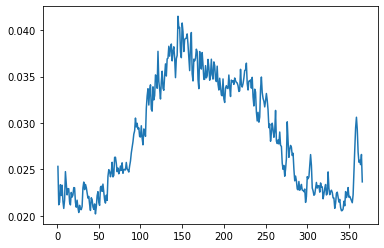

In [73]:
fig, ax = plt.subplots()

sums = dfHydro.join(dfLoad).sum(axis = 0)

dfScaled = dfHydro["HydroVolume"].div(dfLoad["Volume"])
#ax.pie([sums["Volume"]- sums["HydroVolume"], sums["HydroVolume"]])
ax.plot(dfScaled.groupby(dfScaled.index.dayofyear).mean())

# Autokorrelation und partielle Autokorrellation nach Differenzierung

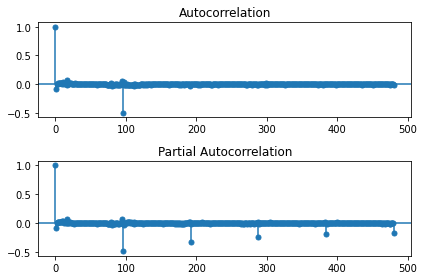

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1)
plot_acf(dfHydro["HydroVolumeDiff"], lags = 96*5, ax = axs[0])
plot_pacf(dfHydro["HydroVolumeDiff"], lags = 96*5, ax = axs[1])
fig.tight_layout()

# Darstellung der Produktion und verschiedener Wettereinflüsse

2802.2604166666665


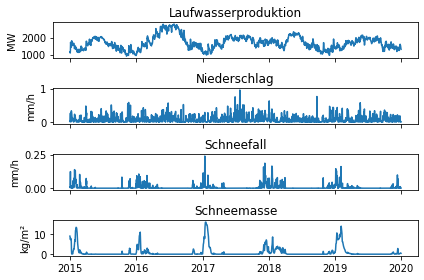

In [99]:
fig, axs = plt.subplots(4,1, sharex = True)

dfJoined = dfHydro.join(dfWeather).drop("Id", axis = 1).dropna().resample('15min').ffill()
dfJoined = dfJoined.groupby(dfJoined.index.date).mean()

print(dfJoined["HydroVolume"].max())

axs[0].plot(dfJoined["HydroVolume"])
axs[0].set_ylabel("MW")
axs[0].set_title("Laufwasserproduktion")
axs[1].plot(dfJoined["Precipitation"])
axs[1].set_ylabel("mm/h")
axs[1].set_title("Niederschlag")
axs[2].plot(dfJoined["Snowfall"])
axs[2].set_ylabel("mm/h")
axs[2].set_title("Schneefall")
axs[3].plot(dfJoined["Snow_mass"])
axs[3].set_ylabel("kg/m²")
axs[3].set_title("Schneemasse")
fig.tight_layout()

# Statistiken und Fehler
Berechnung der Standardabweichung der Leistung und skalierten Leistung. Danach werden AR Modelle berechnet, um die Prognosefehler für Stunden, 2 Stunden, 6 Stunden, Tages-, Wochen- und Monatsprognose

In [101]:
print(dfHydro.std())

dfDiff = diff(dfHydro)

print(dfDiff.std())



HydroVolume    382.046694
HydroScaled      0.009872
dtype: float64
HydroVolume    9.041579
HydroScaled    0.000234
dtype: float64


In [114]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def autoCorrelationAndForecastErrors(ts, groupby, order_ar = 2):
    fig, axs = plt.subplots(3,1)
    grouped = ts.groupby(groupby).mean()
    plot_acf(grouped, ax = axs[0])
    plot_pacf(grouped, ax = axs[1])
    axs[2].plot(grouped.values)
    model = ARIMA(grouped, order = (order_ar,0,0)).fit()
    print("Standardabweichung")
    print(grouped.std())
    print("Modell RMSE")
    print(np.sqrt(model.mse))
    fig.tight_layout()

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood

Standardabweichung
0.00981876598200718
Modell RMSE
0.002206627345710432


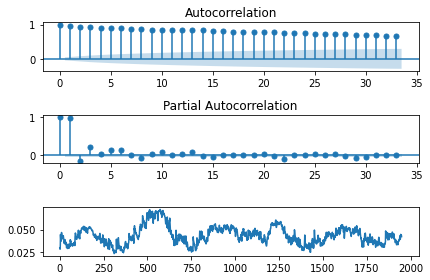

In [115]:
autoCorrelationAndForecastErrors(dfHydro["HydroScaled"], dfHydro.index.date)

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An

Standardabweichung
0.009608572558423612
Modell RMSE
0.003619716142398635


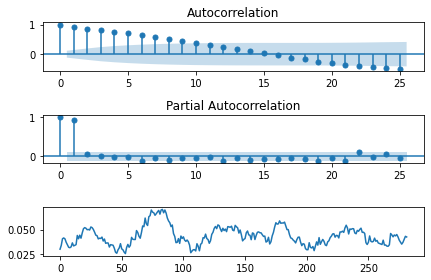

In [116]:
autoCorrelationAndForecastErrors(dfHydro["HydroScaled"], [dfHydro.index.year, dfHydro.index.week])

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Standardabweichung
0.00925289817944537
Modell RMSE
0.005349048721893758


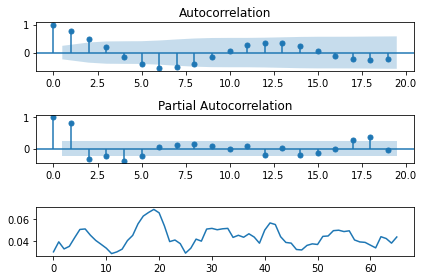

In [117]:
autoCorrelationAndForecastErrors(dfHydro["HydroScaled"], [dfHydro.index.year, dfHydro.index.month])

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Standardabweichung
0.009870590764195391
Modell RMSE
0.0003629127689440659


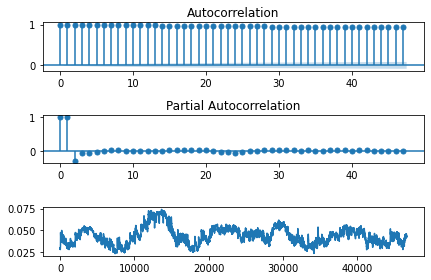

In [120]:
autoCorrelationAndForecastErrors(dfHydro["HydroScaled"], [dfHydro.index.date, dfHydro.index.hour])

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood

Standardabweichung
0.009869458422371604
Modell RMSE
0.0005104373605334424


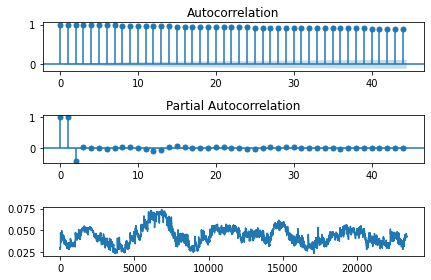

In [124]:
tsResampled = dfHydro["HydroScaled"].resample('2h').mean().dropna()
autoCorrelationAndForecastErrors(tsResampled, tsResampled.index)

C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\studt\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood

Standardabweichung
0.009862577250781225
Modell RMSE
0.0010319190719421936


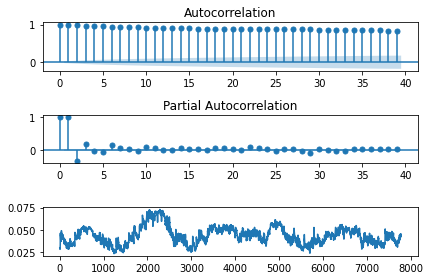

In [125]:
tsResampled = dfHydro["HydroScaled"].resample('6h').mean().dropna()
autoCorrelationAndForecastErrors(tsResampled, tsResampled.index)